In [1]:
from validphys.api import API
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.colors import LogNorm
import sys
from collections import namedtuple

# Add the path to the library folder
sys.path.append('./lib')

from model import PDFmodel
from validphys.api import API

from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

In [2]:
seed = 14132124

In [3]:
evol_basis = np.array([
  'gamma',
  'Sigma',
  'g',
  'V',
  'V3',
  'V8',
  'V15',
  'V24',
  'V35',
  'T3',
  'T8',
  'T15',
  'T24',
  'T35'
])

evol_basis_tex = np.array([
  r'$\gamma$',
  r'$\Sigma$',
  r'$g$',
  r'$V$',
  r'$V_3$',
  r'$V_8$',
  r'$V_{15}$',
  r'$V_{24}$',
  r'$V_{35}$',
  r'$T_3$',
  r'$T_8$',
  r'$T_{15}$',
  r'$T_{24}$',
  r'$T_{35}$'
])

In [61]:
def generate_dicts(common_dict):
  """Collect the necessary data from `validphys` given a validphys-like
  dictionary.

  Returns
  -------
  Returns a named tuple with the following fields:
  - fk_tables: dict
    Dictionary of FK tables.
  - central_data: dict
    Dictionary of central data.
  - xgrid: np.array
    The largest grids amongst all datasets.
  - total_ndata_wc: int
    Total number of data points.
  - lumi_mapping: np.array
    Luminosity mapping.
  """
  groups_data = API.procs_data(**common_dict)

  # Initialize named tuple
  result_tuple = namedtuple('result_tuple', ('fk_tables', 'central_data', 'xgrid', 'total_ndata_wc', 'lumi_mapping'))

  # Initialise the dictionaries
  fk_table_dict = {}
  central_data_dict = {}
  lumi_mapping = np.array([])
  flag = True

  XGRID = np.array([])


  total_ndata_wc = 0
  for group_proc in groups_data:
    for exp_set in group_proc.datasets:
      dataset_name = exp_set.name
      dataset_size = exp_set.load_commondata().ndata
      total_ndata_wc += dataset_size
      cuts = exp_set.cuts
      central_data_dict[dataset_name] = exp_set.load_commondata().with_cuts(cuts).central_values.to_numpy()

      # Collect FKSpecs
      fk_data = exp_set.fkspecs[0].load_with_cuts(cuts)

      # Read FKData and FK table in numpy version
      fk_table = fk_data.get_np_fktable()
      fk_table_dict[dataset_name] = fk_table

      # Collect lumi mapping
      if flag:
        lumi_mapping = np.array(fk_data.luminosity_mapping)
        flag = False
      if not np.allclose(lumi_mapping, np.array(fk_data.luminosity_mapping)):
        raise ValueError('Lumi mapping is not the same for all datasets.')

      # xgrid for this dataset
      xgrid = fk_data.xgrid
      if xgrid.size > XGRID.size:
        XGRID = xgrid

      # Check that `large_xgrid` is just a small-x extension of xgrid
      for i, x in enumerate(xgrid):
        offset = XGRID.size - xgrid.size
        try:
          assert(np.isclose(x, XGRID[offset+i]))
        except AssertionError:
          print(f"`large_xgrid` is not an extension for {dataset_name}.")

  res = result_tuple(fk_tables=fk_table_dict, central_data=central_data_dict, xgrid=XGRID, total_ndata_wc=total_ndata_wc, lumi_mapping=lumi_mapping)
  return res


def pad_fk_tables(fk_table_dict, grid_size):
  res_dict = {}
  for dataset_name, fk_table in fk_table_dict.items():
    res_dict[dataset_name] = np.pad(fk_table, ((0, 0), (0,0), (grid_size - fk_table.shape[2], 0)), 'constant')
  return res_dict


def build_fk_matrix(fk_dict):
   """
   Construct the FK table matrix.

   Description
   -----------
   Each experiment is provided with an FK table. By construction, and
   for the present work, FK tables are padded with zeros such that
   the number of points in the x-grid is the same (i.e. 50). Thus,
   each FK table has shape (Ndat, 50, 9). First, the last two dimensions
   (which are equal for all FK tables) are flattened, thus leaving 
   the shape (Ndat, 450). Then, all FK tables are stacked together,
   yielding a matrix (tot_Ndat, 450), where `tot_Ndata` is the sum
   off all experimental point. In this way, each row of this matrix
   represents an experimental point and contains the information to
   compute its relative theoretical prediction.

   Parameters
   ----------
   fk_dict: dict
    Dictionary of FK tables.
   """
   ndata = 0
   for fk in fk_dict.values():
      ndata += fk.shape[0]

   FK = np.vstack([fk.reshape((fk.shape[0], fk.shape[1] * fk.shape[2])) for fk in fk_dict.values()])

   # Check that this FK is what we expect
   try:
     test_matrix = np.random.rand(FK.shape[0], FK.shape[0]) # Random matrix
     mat_prod = FK.T @ test_matrix  # Matrix product
 
     # Tensor product
     result = np.zeros((fk.shape[1], fk.shape[2], FK.shape[0]))
     I = 0
     for fk in fk_dict.values():
       ndata = fk.shape[0]
       result += np.einsum('Iia, IJ -> iaJ',fk, test_matrix[I : I + ndata, :])
       I += ndata
     
     result_flatten = result.reshape((result.shape[0] * result.shape[1], result.shape[2]))
     assert(np.allclose(result_flatten, mat_prod))
     assert(np.allclose(result, mat_prod.reshape((result.shape[0], result.shape[1], result.shape[2]))))
   except AssertionError:
     print('The FK matrix does not match with the FK dict.')
   else:
      return FK
   

def plot_matrix(matrix, x_labels, x_ticklocks, size=(20,20), fontsize=10, pad=10, y_labels=None, y_ticklocks=None):
  # Show the FK tables
  fig, ax = plt.subplots(figsize=size)
  matrixplot = ax.matshow(
      matrix,
      cmap=cm.Spectral_r,
      norm=mcolors.SymLogNorm(
          linthresh=0.00001, linscale=1, vmin=matrix.min(), vmax=matrix.max()
      ),
  )
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.5)
  cbar = fig.colorbar(matrixplot, cax=cax)
  cbar.ax.tick_params(labelsize=fontsize)

  ax.set_xticks(x_ticklocks)
  _ = ax.set_xticklabels(x_labels, rotation=20, ha="left", fontsize=fontsize)

  if y_labels is not None and y_ticklocks is not None:
    ax.set_yticks(y_ticklocks)
    _ = ax.set_yticklabels(y_labels, rotation=20, ha="left", fontsize=fontsize)
    ax.tick_params(axis='y', pad=pad)

  return fig, ax

In [39]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=708,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [40]:
# Retrieve data from NNPDF
tuple_of_dicts = generate_dicts(common_dict)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
lumi_mapping = tuple_of_dicts.lumi_mapping
XGRID = tuple_of_dicts.xgrid

fk_table_dict_padded = pad_fk_tables(fk_table_dict, XGRID.size)
FK = build_fk_matrix(fk_table_dict_padded)

(<Figure size 2000x2000 with 2 Axes>, <Axes: >)

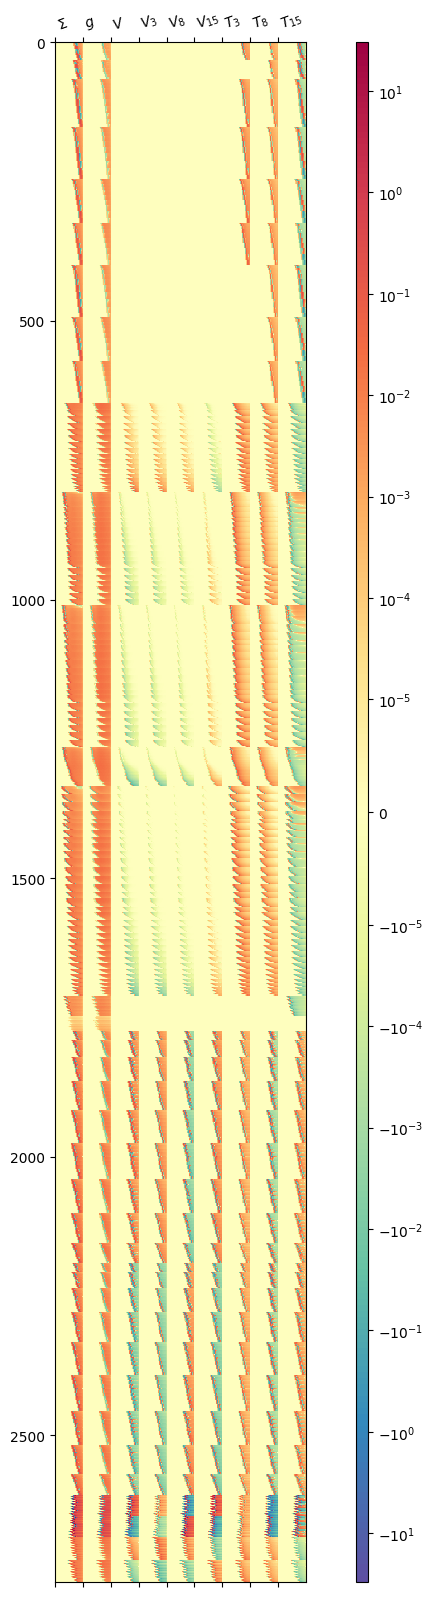

In [41]:
plot_matrix(FK, x_labels=evol_basis_tex[lumi_mapping] , x_ticklocks=np.arange(0, FK.shape[1], XGRID.size))

In [42]:
C = API.groups_covmat_no_table(**common_dict)
Cinv = pd.DataFrame(np.linalg.inv(C), index=C.index, columns=C.columns)

# Diagonalize covariance matrix
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.diag(eigvals_Cinv)

In [43]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    # (group, experiment, index)
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [44]:
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

# Computing matrices from notes
-------------------------------

In [45]:
def regularize_matrix_svd(M, hermitean: bool = False, tol: float = None):
   """
   Regularization of a matrix wither with svd or evd depending
   on whether the matrix is symmetric or not.

   Description
   -----------
   When dealing with numerical precision issues in matrices (e.g. symmetric 
   matrices with eigenvalues spanning a very large range) regularization turns
   out to be essential. If the matrix is symmetric, the regularization is applied
   to the eigenvalues; if the matrix is not symmetric, the regularization is
   applied to the singular values. The tolerance, which defines the smallest
   distinguishable difference, is eps * max(s) where eps is the machine epsilon
   (~2.2e-16 for float64) and max(s) is the highest eigenvalue or the highest
   singular value.

   Parameters
   ----------
   M: np.ndarray
    The matrix that needs to be regularized. The matrix must be squared.
   tol: float
    The tolerance that defines the smallest distinguishable value. Default is None,
    and the tolerance is defined as eps * max(s).

   Returns
   -------
   If the matrix is symmetric, it returns the regularized matrix and a tuple
   containing the regularized eigenvalues in first position and the respective
   eigenvectors in second position. If the matrix is not symmetric, it returns
   the regularized matrix, and a tuple (U, S_reg, Vh).
   """
   U, S, Vh = np.linalg.svd(M, full_matrices=False, hermitian=hermitean)
   if tol is None:
     tol = np.amax(S, initial=0.) * np.finfo(M.dtype).eps
   reg_S = np.where(S > tol, S, 0.0)
   M_reg = np.dot(U * reg_S, Vh)
      
   return M_reg, (reg_S, Vh, U, tol)

# $M = (FK)^T C_Y^{-1} (FK) = RDR^T$
Here I compute the matrix $M$ as defined above. Then I check that the SVD gives the same result as the eigen decomposition

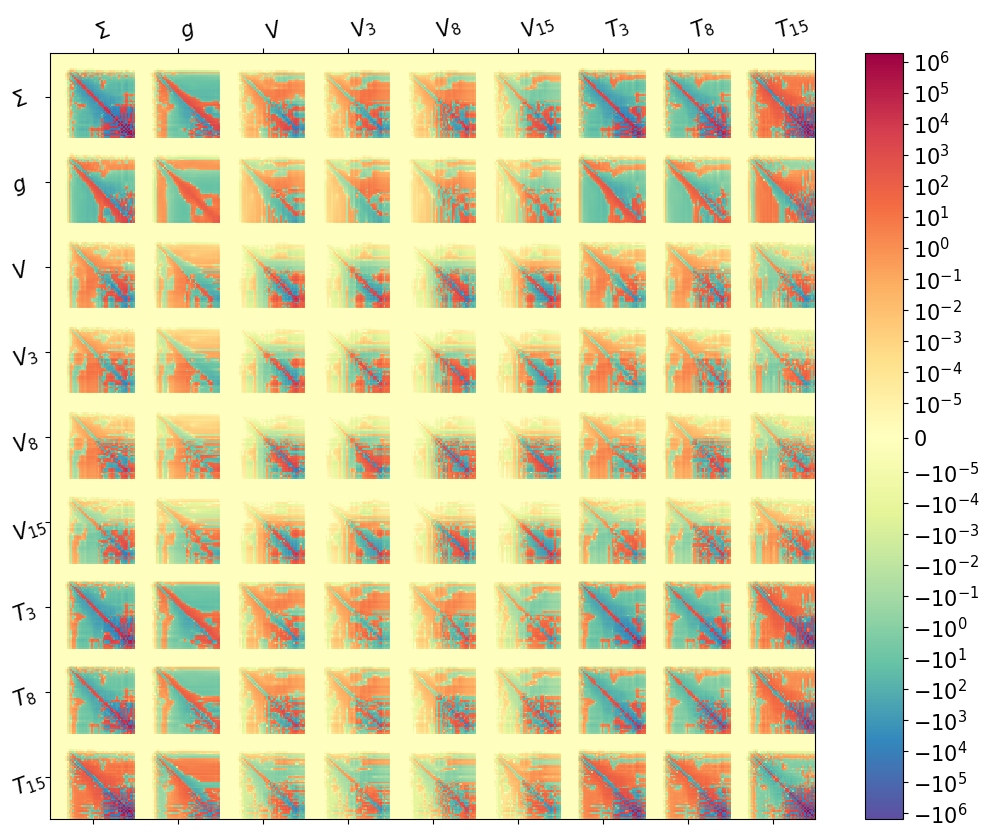

In [ ]:
# Compute M and make a copy
M = FK.T @ Cinv.to_numpy() @ FK

# Check that M is symmetric
assert(np.allclose(M, M.T))

# Plot M
fig, _ = plot_matrix(M, 
                     x_ticklocks=np.arange(XGRID.size//2, M.shape[1] + XGRID.size//2, XGRID.size), 
                     x_labels=evol_basis_tex[lumi_mapping],
                     y_ticklocks=np.arange(XGRID.size//2, M.shape[1] + XGRID.size//2, XGRID.size), 
                     y_labels=evol_basis_tex[lumi_mapping], 
                     size=(10,10), fontsize=15,
                     pad=25)
fig.savefig('./plots/M_matrix.png')

Here we compute the SVD of $M$ and solve the eigensystem associated with it. We find that the eigenvalues and the singular values are the same up to the threshold of numerical precision. This threshold is the machine precision for double float ($\varepsilon \sim 2.2 \times 10^{-16}$) multiplied be the largest singular value. Effectively, this defines the _relative_ tolerance.

Max. singular value : 5.64e+06


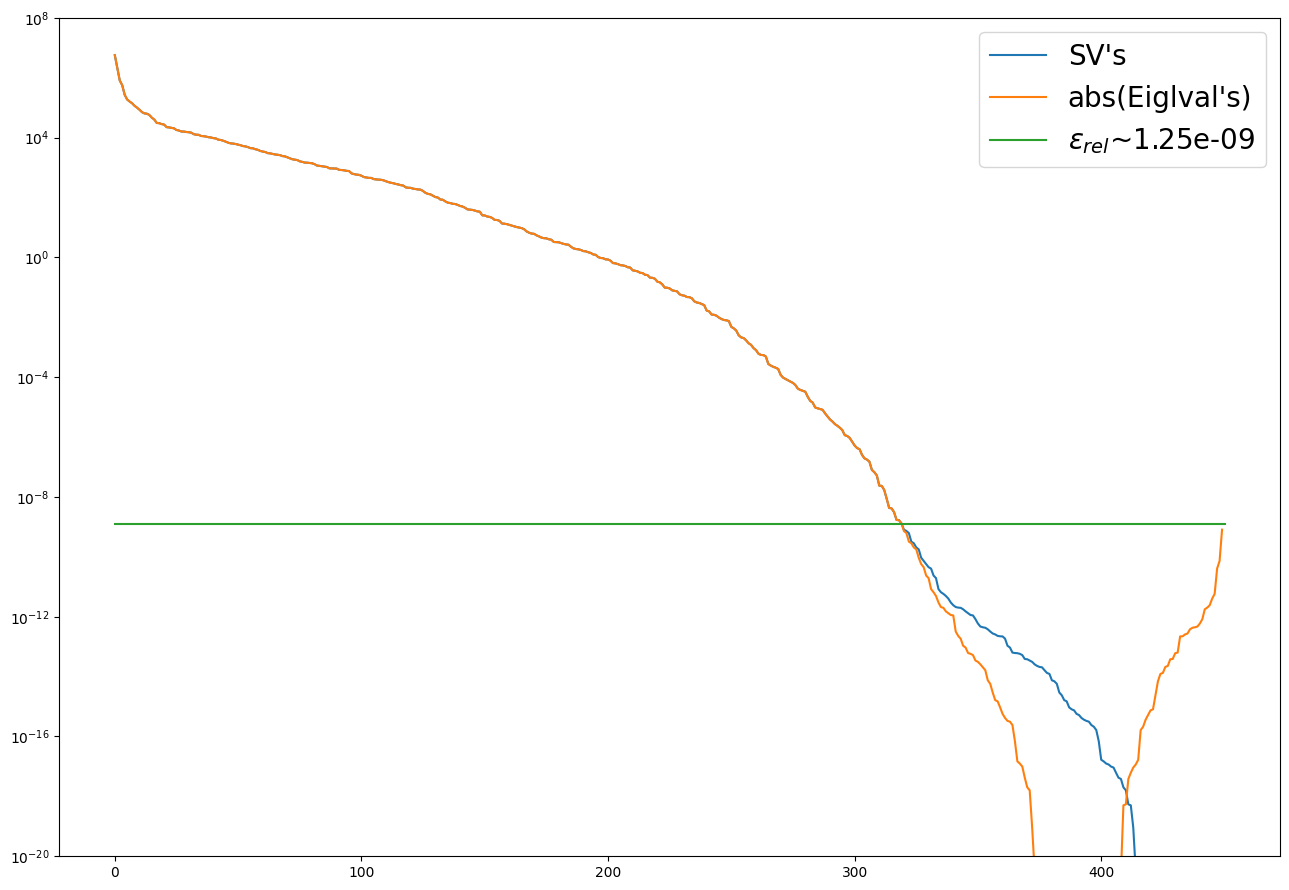

In [64]:
# Compute SVD
U_M, S_M, Vh_M = np.linalg.svd(M, full_matrices=True, hermitian=True)
V_M = Vh_M.T
print(f"Max. singular value : {S_M[0]:.2e}")

# Compute the eigensystem of the regularized matrix
eigvals_M, eigvecs_M = np.linalg.eigh(M)
eigvals_M = eigvals_M[::-1]
eigvecs_M = eigvecs_M[:, ::-1]

# Define tolerance for comparison
rtol = np.amax(S_M, initial=0.) * np.finfo(M.dtype).eps

# Plot singular- and eigen-values
plt.figure(figsize=(13,9))
plt.plot(S_M, label="SV's")
plt.plot(np.abs(eigvals_M), label="abs(Eiglval's)")
plt.plot(np.linspace(0,450,100), [rtol for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{rtol:.2e}')
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('./plots/eig_svd_M.png')

The plot above shows that the two systems are exactly the same up to the numerical precision. Below this threshold, any value should be interpreted as numerical noise and hence must be set to zero. This form of regularization is performed in the following cell.

In [14]:
# Regularize the matrix
M_reg, (S_M_reg, Vh_M, U_M, tol) = regularize_matrix_svd(M, tol=rtol, hermitean=True)

# Regularize the eigenvalues
eigvals_M = [val if val > rtol else 0.0 for val in eigvals_M]

# Find the index of the first null value
arg_first_zero = np.argwhere(eigvals_M < rtol)[0][0]

# Print info
print(f"First non-zero argument : {arg_first_zero}")

First non-zero argument : 320


Note that the eigensystem and the SVD match also in terms of rotation matrix. In fact, we see that $V$ and $U$ from SVD are exactly the same up to the numerical threshold, as shown below:

In [15]:
for i in range(arg_first_zero):
  if not np.allclose(Vh_M.T[:,i], U_M[:,i]):
    print(f"Column {i} is not the same.")
    break

If we go beyond this numerical tolerance, the singular vectors and the eigenvectors start to diverge:

In [16]:
for i in range(arg_first_zero, S_M_reg.size):
  if not np.allclose(Vh_M.T[:,i], U_M[:,i]):
    print(f"Vector {i} is not the same.")
    break

Vector 320 is not the same.


With hindsight, this result is expected. The kernel space is not fixed and there are many directions that are equivalent. This effect is made more severe if the kernel is large.

## Projection in the orthogonal space
The vectors of $U$ associated to the non-zero singular values span the space orthogonal to Ker$(M)$. In this space, $M$ is diagonal, with entries equal to the (non-zero) singular values. The cell below shows how to obtain this subspace:

In [17]:
M_orth = np.diag(S_M_reg[:arg_first_zero])
print(f"Original dimension of the singular space : {S_M_reg.size}")
print(f"Dimension of the orthogonal subspace : {M_orth.shape[0]}")

Original dimension of the singular space : 450
Dimension of the orthogonal subspace : 320


However, the matrix remains ill-conditioned even after the noise is removed:

In [18]:
M_rec_orth = U_M[:, :arg_first_zero].T @ M @ U_M[:, :arg_first_zero]
print(f"Condition number of M in the diagonal basis: {M_orth.diagonal()[0]/M_orth.diagonal()[-1]}")
print(f"Condition number of M in the original basis: {np.linalg.cond(M_rec_orth)}")

Condition number of M in the diagonal basis: 4316029648742186.5
Condition number of M in the original basis: 6643938342819724.0


In order to obtain a good condition number, we need to cut more singular values. The list below displays how the condition number changes with the size of the subspace:

In [19]:
for j in range(arg_first_zero):
  M_orth = np.diag(S_M_reg[:arg_first_zero - j])
  print(f"Condition number of M in the diagonal basis with j = {j}: {M_orth.diagonal()[0]/M_orth.diagonal()[-1]}")

Condition number of M in the diagonal basis with j = 0: 4316029648742186.5
Condition number of M in the diagonal basis with j = 1: 3377067314467445.5
Condition number of M in the diagonal basis with j = 2: 3306059666082117.0
Condition number of M in the diagonal basis with j = 3: 1821377013854289.8
Condition number of M in the diagonal basis with j = 4: 1358055177885222.0
Condition number of M in the diagonal basis with j = 5: 1317090489196737.8
Condition number of M in the diagonal basis with j = 6: 644614496529880.2
Condition number of M in the diagonal basis with j = 7: 329337935603224.9
Condition number of M in the diagonal basis with j = 8: 241213393414731.25
Condition number of M in the diagonal basis with j = 9: 236133833378064.66
Condition number of M in the diagonal basis with j = 10: 107719020699695.78
Condition number of M in the diagonal basis with j = 11: 84241017449953.45
Condition number of M in the diagonal basis with j = 12: 70464490776912.89
Condition number of M in t

Here we cann see how this cut affects the inverse problem

In [80]:
cut_size = [100, 150, 250, 300]
reduced_space_size = [arg_first_zero - j for j in cut_size]
M_orth = [np.diag(S_M_reg[:reduced_space]) for reduced_space in reduced_space_size]
M_orth_inv = [np.linalg.inv(M_orth_i) for M_orth_i in M_orth]
FK_orth = [FK @ U_M[:, :reduced_space] for reduced_space in reduced_space_size]

print(f"Studying the following reduced dimensions:")
for i in range(len(cut_size)):
  print(f"Reduced dimension: {reduced_space_size[i]}")

# Test that the explicit projection is the diagonal matrix M_orth defined above
for i in range(len(cut_size)):
  M_test = U_M[:, :reduced_space_size[i]].T @ M @ U_M[:, :reduced_space_size[i]]
  assert(np.allclose(M_test, M_orth[i]))

Studying the following reduced dimensions:
Reduced dimension: 220
Reduced dimension: 170
Reduced dimension: 70
Reduced dimension: 20


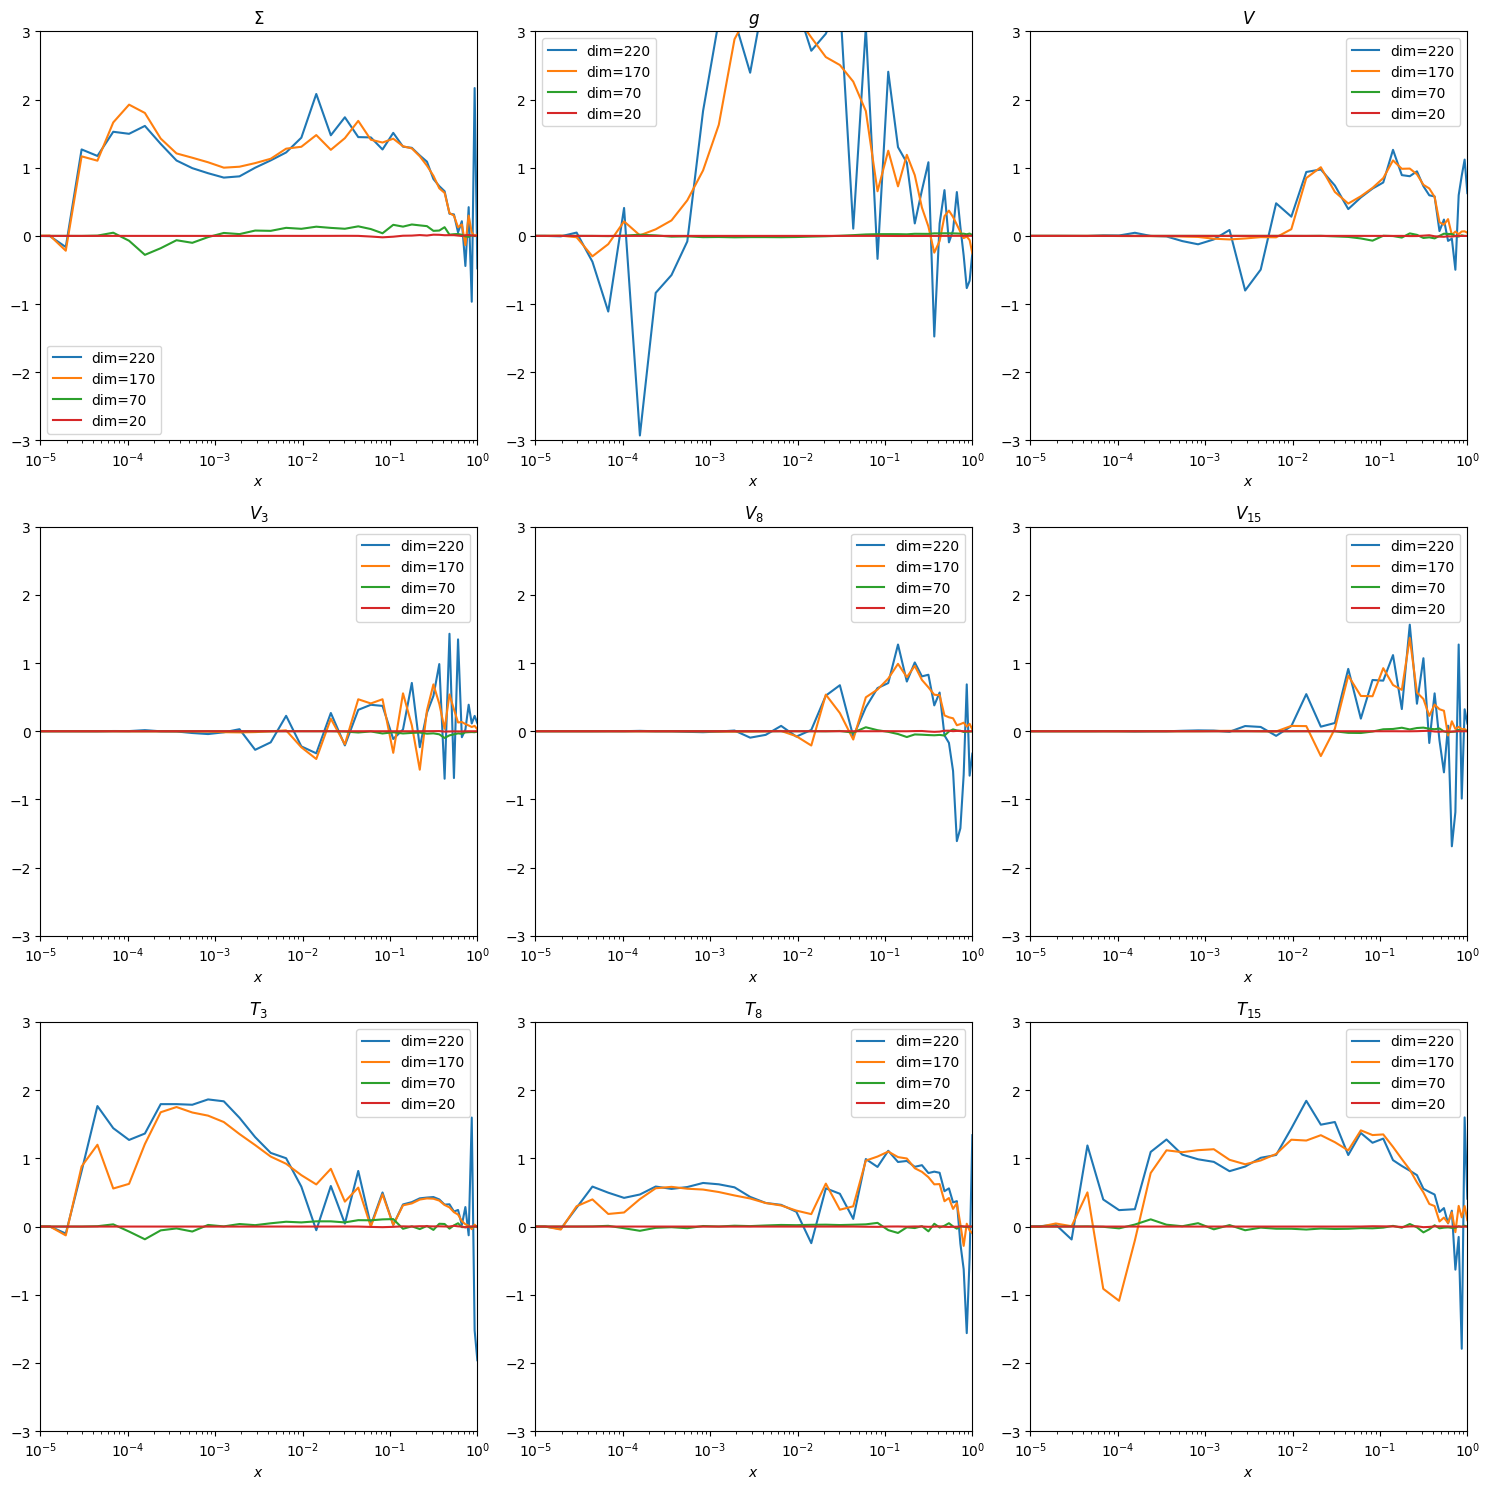

In [83]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

f_inf_list = []
eps_inf_list = []
L_inf_list = []

for i in range(len(cut_size)):
  f_inf = M_orth_inv[i] @ FK_orth[i].T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy(dtype='float64')[:,0]
  eps_inf = Y.to_numpy(dtype='float64')[:,0] - FK_orth[i] @ f_inf
  L_inf = 0.5 * Y.to_numpy(dtype='float64')[:,0].T @ Cinv.to_numpy(dtype='float64') @ eps_inf / Y.size
  f_inf_list.append(f_inf)
  eps_inf_list.append(eps_inf)
  L_inf_list.append(L_inf)


  f = U_M[:, :reduced_space_size[i]] @ f_inf
  f = f.reshape((9, f.size // 9))


  for j, ax in enumerate(axs.flatten()):
    flav_label = evol_basis_tex[lumi_mapping[j]]
    ax.plot(XGRID, f[j], label=f"dim={reduced_space_size[i]}")
    ax.set_title(flav_label)
    ax.set_xscale('log')
    ax.set_xlim([1.e-5, 1.])
    ax.set_ylim([-3., 3.])
    ax.set_xlabel(r'$x$')
    ax.legend()

fig.tight_layout()
fig.savefig('./plots/f_inf.png')

# $\tilde{H_{\epsilon}} = D_Y^{1/2} R_Y^T (FK) \Theta (FK)^T R_Y D_Y^{1/2}$

Max. singular value : 1.34e+07


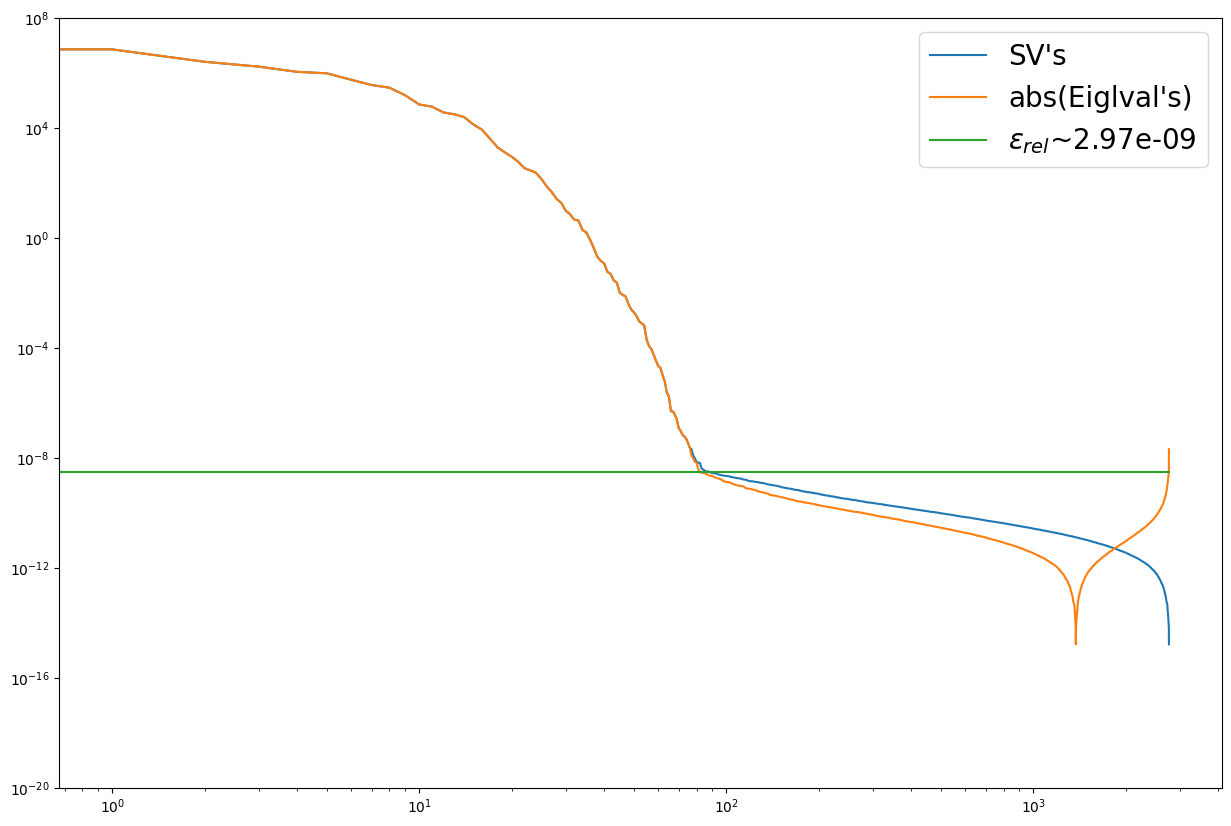

In [85]:
# Set the size of the orthogonal space
reduced_space_size = arg_first_zero - 150

# Compute matrices and vectors required later
M_orth = np.diag(S_M_reg[:reduced_space_size])
M_orth_inv = np.linalg.inv(M_orth)
FK_orth = FK @ U_M[:, :reduced_space_size]
f_inf = M_orth_inv @ FK_orth.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy(dtype='float64')[:,0]
eps_inf = Y.to_numpy(dtype='float64')[:,0] - FK_orth @ f_inf

# Compute Hte
ntk = U_M[:, :reduced_space_size].T @ NTK_flat @ U_M[:, :reduced_space_size]
Hte = np.sqrt(D_Y) @ R_Y.T @ FK_orth @ ntk @ FK_orth.T @ R_Y @ np.sqrt(D_Y)


# Compute SVD
U_hte, S_hte, Vh_hte = np.linalg.svd(Hte, full_matrices=True, hermitian=True)

# Compute eigenvalues
eigvals_Hte, eigvecs_Hte = np.linalg.eigh(Hte)
eigvals_Hte = eigvals_Hte[::-1]
eigvecs_Hte = eigvecs_Hte[:, ::-1]

# Define tolerance
rtol = np.amax(S_hte, initial=0.) * np.finfo(Hte.dtype).eps

# Plot singular values and eigenvalues
plt.figure(figsize=(15,10))
plt.plot(S_hte, label="SV's")
plt.plot(np.abs(eigvals_Hte), label="abs(Eiglval's)")
plt.plot(np.linspace(0,eigvals_Hte.size,100), [rtol for _ in range(100)], label=r'$\varepsilon_{rel}$' +  f'~{rtol:.2e}')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend(fontsize=20)

print(f"Max. singular value : {S_hte[0]:.2e}")
assert(np.allclose(Hte, Hte.T))

In [86]:
# Regularize the matrix
Hte, (S_hte_reg, Vh_hte, U_hte, tol) = regularize_matrix_svd(Hte, tol=rtol, hermitean=True)

# Regularize the eigenvalues
eigvals_Hte = [val if val > rtol else 0.0 for val in eigvals_Hte]

# Reconstruct the pseudo-inverse
S_hte_reg_dag = [1/val if val != 0.0 else 0.0 for val in S_hte_reg]
Hte_my_pinv = Vh_hte.T @ np.diag(S_hte_reg_dag) @ U_hte.T

We also compute the following quantity, which will be useful in the description of the evolution
$$
\begin{align}
& \tilde{\varepsilon}_{\infty} = D_{Y}^{1/2} \, R_Y^T \varepsilon_{\infty} \hspace{5mm} \textrm{where} \hspace{5mm} C_Y^{-1} = R_Y D_Y R_Y^T \\
\end{align}
$$

In [87]:
eps_inf_tilde = np.sqrt(D_Y) @ R_Y.T @ eps_inf

We now check eq.(67) of the paper, that is
$$
\tilde{H}_{\varepsilon} \, \tilde{\varepsilon}_{\infty} = 0
$$

In [88]:
res = Hte @ eps_inf_tilde
print(f"max value of res : {np.amax(res)}")
print(f"min value of res : {np.amin(res)}")

max value of res : 2.5543849915266037e-06
min value of res : -4.030065611004829e-06


In [89]:
np.linalg.norm(res)

1.3397426560769078e-05

In [90]:
arg_first_zero

320